#### ROUTING GAME LIBRARY

In [1]:
include("routing_games.jl")
# calling by
# game_name, g, p, E, s, x̂ = grid_graph3_4_players()
# game_name, g, p, E, E_diag, s_reduced, x̂ = grid_graph3_4_players_reduced()

plot_labeled (generic function with 1 method)

#### FORWARD SOLVER: game(p,E,s, b, C) ==> (x, v)

In [2]:
include("entropy_routing_solver_nlsolve.jl")
# include("solve_entropy_routing_jump.jl")


# calling by:
# x, v = solve_entropy_routing(pa(), 0.01)

solve_entropy_routing (generic function with 1 method)

##### test forward solver

In [3]:
game_name, g, p, E, E_diag, s_reduced, x̂ = grid_graph3_4_players_reduced()
n, m = size(E)
b = 0.1*ones(p*m)
C = zeros(p*m, p*m)

x_init = zeros(p*m)
v_init = zeros(p*(n-1))

# create parameters block and solve for x
function pa()
    pa_p = p
    pa_E = E
    pa_E_diag = E_diag
    pa_n, pa_m = n, m
    pa_s_reduced = s_reduced
    pa_b = b
    pa_C = C
    (; p=pa_p, E=pa_E, E_diag=pa_E_diag, n=pa_n, m=pa_m, s_reduced=pa_s_reduced, b=pa_b, C=pa_C)
end
x, v = solve_entropy_routing(pa(), 0.01, x_init, v_init)

(x = [0.00407009972134608, 6.853544908988698e-8, 6.853559354112621e-8, 0.004070099696586628, 1.6701705219996273e-5, 6.853553124499178e-8, 0.004070099696363699, 0.0040700997212016286, 0.991859937909731, 0.0040700997212016286  …  0.0040700996965866276, 1.6701705219996266e-5, 6.853559354112621e-8, 0.004070099721346079, 6.853544908988699e-8, 0.9918599379097309, 0.004070099721201628, 0.0040700997212016286, 0.00407009972134608, 6.853544908988699e-8], v = [0.16487739783993682, 0.10991827366600597, 0.0549591449834794, 0.21983653253812874, 0.1099182662693196, 0.16487739783993682, 0.10991827366600597, 0.0549591449834794, 0.0549591449834794, 0.10991827366600597  …  0.0549591449834794, 0.0549591449834794, 0.0549591449834794, 0.0549591449834794, 0.10991827366600597, 0.1099182662693196, 0.10991827366600597, 0.16487739783993682, 0.21983653253812874, 0.16487739783993682])

#### BACKWARD SOLVER: (p,E,s, x_hat) ==> (b, C)

In [4]:
include("approx_proj_gradient.jl")
# calling by:
# x, b, C, ψ_vals, violation_metrics, lambda_vals, v, ∇̂ψ_C_norm, D_norm, J_norm, pinv_J_norm, F_norm = approx_proj_grad(p, E_diag, E, s_reduced, x̂, λ, α, ϵ, ρ, max_iter, x, b, C)

approx_proj_grad

##### test backward solver

In [5]:
game_name, g, p, E, E_diag, s_reduced, x̂ = grid_graph3_4_players_reduced()
n, m = size(E)
b = 0.1*ones(p*m)
C = zeros(p*m, p*m)

# assign parameters
λ = 0.01
α = 0.005
ϵ = 1e-3
ρ = 0.5
max_iter = 10

println("----------- $(game_name)_λ=($λ)_α=($α)_ϵ=($ϵ)_ρ=($ρ) -----------")
x, x_init, b, C, ψ_vals = approx_proj_grad(p, E, E_diag, s_reduced, x̂, λ, α, ϵ, ρ, max_iter, x, b, C)

----------- grid_graph3_4_players_reduced_λ=(0.01)_α=(0.005)_ϵ=(0.001)_ρ=(0.5) -----------


Starting approx proj grad...


(x = [0.9999836615149487, 4.918795859514395e-8, 4.934843385282582e-8, 0.9999837023478465, 1.6674582320921938e-5, 4.947058906877727e-8, 0.9999837024052136, 0.9999836613544735, 6.918450880220515e-11, 1.64371390247781e-5  …  0.0013946175902925584, 2.119683599662598e-5, 1.0266204883076648e-10, 1.0290527061535641e-7, 1.0866496057460145e-10, 0.9985972169957589, 1.0290632356340696e-7, 0.0014026803512088761, 0.0014026803092451405, 1.4462578448489076e-10], b = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], C = [0.014752437273473142 1.2704521140347478e-5 … -0.005837398081685063 -7.301244475838251e-10; 1.2704521140347478e-5 1.8467421991157355e-8 … 4.176572469423792e-7 7.503654440366826e-15; … ; 0.005304196401840842 -1.106413318136385e-6 … 0.004649614443025156 -5.375960557886024e-10; -6.517970270959227e-11 6.115360940576484e-15 … -5.375960557886024e-10 7.30581127477861e-15], ψ_vals = [11.870287863355856, 9.851332218615463, 1.731425734561042

#### RUNNING

In [6]:
function homotopy_exp_parameter_choice(p, E, E_diag, s_reduced, x̂, λ_list, α, ϵ, ρ, max_iter)
    n, m = size(E)

    # output placeholder
    x = zeros(p*m)
    b = 0.1*ones(p*m)
    C = zeros(p*m, p*m)
    v = zeros(p*(n-1))
    
    ψ_vals_list = Float64[]
    violation_metrics_list = Float64[]
    lambda_vals_list = Float64[]
    ∇̂ψ_C_norm_list = Float64[]
    D_norm_list = Float64[]
    J_norm_list = Float64[]
    pinv_J_norm_list = Float64[]
    F_norm_list = Float64[]

    for λ in λ_list
        println("λ=$λ, α=$α")
        x, b, C, ψ_vals, violation_metrics, lambda_vals, v, ∇̂ψ_C_norm, D_norm, J_norm, pinv_J_norm, F_norm = approx_proj_grad(p, E, E_diag, s_reduced, x̂, λ, α, ϵ, ρ, max_iter, x, b, C)
        append!(ψ_vals_list, ψ_vals)
        append!(violation_metrics_list, violation_metrics)
        append!(lambda_vals_list, lambda_vals)
        append!(∇̂ψ_C_norm_list, ∇̂ψ_C_norm)
        append!(D_norm_list, D_norm)
        append!(J_norm_list, J_norm)
        append!(pinv_J_norm_list, pinv_J_norm)
        append!(F_norm_list, F_norm)
    end
    
    (;x = x,
      b = b,
      C = C,
      ψ_vals_list = ψ_vals_list,
      violation_metrics_list = violation_metrics_list,
      lambda_vals_list = lambda_vals_list,
      v = v,
      ∇̂ψ_C_norm_list = ∇̂ψ_C_norm_list,
      D_norm_list = D_norm_list,
      J_norm_list = J_norm_list,
      pinv_J_norm_list = pinv_J_norm_list,
      F_norm_list = F_norm_list)
end

homotopy_exp_parameter_choice (generic function with 1 method)

In [7]:
using JLD2

# instantiate a routing game (p, E, s) with desired Nash sol x̂
game_name, g, p, E, E_diag, s_reduced, x̂ = grid_graph3_4_players_reduced()

# assign parameters
α = 0.005
ϵ = 1e-3
ρ = 0.5
max_iter = 10
@show λ_list = [1.0/(2^i) for i in 1:8]

# create an individual folder under homotopy_results/
dir = "homotopy_results/$(game_name)"; mkpath(dir) # mkdir if not exists

λ_list = [1.0 / 2 ^ i for i = 1:8] = [0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625]


"homotopy_results/grid_graph3_4_players_reduced"

In [8]:
""" RUNNING EXP: PARAMETER CHOICE """
# calling method
println("----------- $(game_name)_ρ=($ρ)_λ_list=($λ_list)_α=($α)_ϵ=($ϵ) -----------")
x, b, C, ψ_vals_list, violation_metrics_list, lambda_vals_list, v, ∇̂ψ_C_norm_list, D_norm_list, J_norm_list, pinv_J_norm_list, F_norm_list = homotopy_exp_parameter_choice(p, E, E_diag, s_reduced, x̂, λ_list, α, ϵ, ρ, max_iter)

# save data to folder
println("saving result to '$dir/$(game_name)_λ_list=($λ_list)_homotopy.jld2'")
@save "$dir/$(game_name)_λ_list=($λ_list)_homotopy.jld2" ρ λ_list α ϵ max_iter lambda_vals_list ψ_vals_list violation_metrics_list v ∇̂ψ_C_norm_list D_norm_list J_norm_list pinv_J_norm_list F_norm_list
println("--------------------------------")

----------- grid_graph3_4_players_reduced_ρ=(0.5)_λ_list=([0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625])_α=(0.005)_ϵ=(0.001) -----------


λ=0.5, α=0.005
Starting approx proj grad...


λ=0.25, α=0.005
Starting approx proj grad...


λ=0.125, α=0.005
Starting approx proj grad...


λ=0.0625, α=0.005
Starting approx proj grad...


λ=0.03125, α=0.005
Starting approx proj grad...


λ=0.015625, α=0.005
Starting approx proj grad...


λ=0.0078125, α=0.005
Starting approx proj grad...


λ=0.00390625, α=0.005
Starting approx proj grad...


saving result to 'homotopy_results/grid_graph3_4_players_reduced/grid_graph3_4_players_reduced_λ_list=([0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625])_homotopy.jld2'


--------------------------------


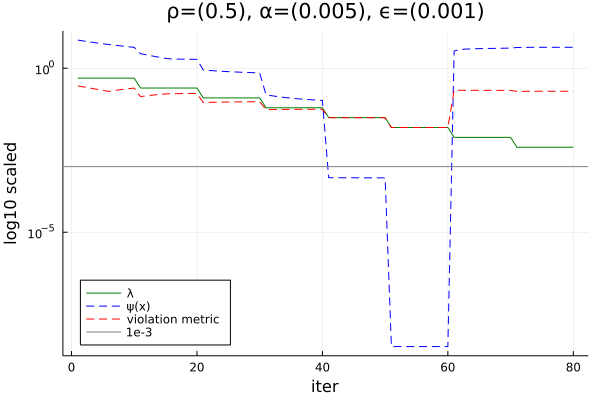

saving plot to 'homotopy_results/grid_graph3_4_players_reduced/grid_graph3_4_players_reduced_λ_list=([0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625])_homotopy.png'


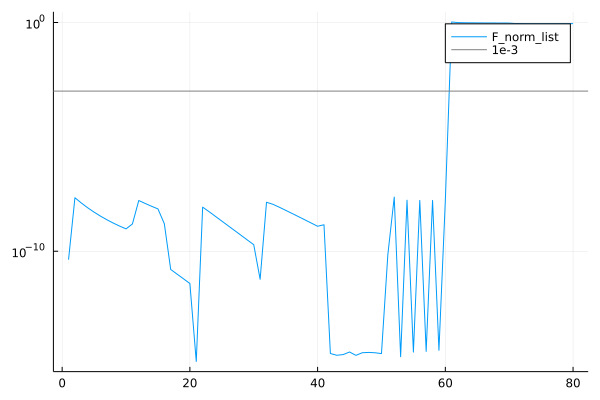

saving plot to 'homotopy_results/grid_graph3_4_players_reduced/grid_graph3_4_players_reduced_λ_list=([0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625])_helper_metrics.png'


In [9]:
using Plots, IJulia
mkpath("current_homotopy")

@load "$dir/$(game_name)_λ_list=($λ_list)_homotopy.jld2" ρ λ_list α ϵ max_iter lambda_vals_list ψ_vals_list violation_metrics_list v ∇̂ψ_C_norm_list D_norm_list J_norm_list pinv_J_norm_list F_norm_list

# plot single axis (log-scaled)
p1 = plot(lambda_vals_list, yscale=:log10, c=:green, label="λ", leg=:bottomleft, xlabel="iter", ylabel="log10 scaled")
plot!(ψ_vals_list, yscale=:log10, c=:blue, linestyle=:dash, label="ψ(x)", leg=:bottomleft)
plot!(violation_metrics_list, yscale=:log10, c=:red, linestyle=:dash, label="violation metric", leg=:bottomleft)
hline!([1e-3], label="1e-3", c=:grey)
plot!(title="ρ=($ρ), α=($α), ϵ=($ϵ)")
println("saving plot to '$dir/$(game_name)_λ_list=($λ_list)_homotopy.png'")
savefig("$dir/$(game_name)_λ_list=($λ_list)_homotopy.png")
IJulia.display(p1)

# plot helper_metrics_plot
# plot!(pinv_J_norm_list, label="pinv_J_norm_list", yscale=:log10)
p2 = plot(F_norm_list, label="F_norm_list", yscale=:log10)
# plot!(∇̂ψ_C_norm_list, label="∇̂ψ_C_norm_list", yscale=:log10, leg=:bottomleft)
# plot!(D_norm_list, label="D_norm_list", yscale=:log10)
# plot!(J_norm_list, label="J_norm_list", yscale=:log10)
hline!([1e-3], label="1e-3", c=:grey)
println("saving plot to '$dir/$(game_name)_λ_list=($λ_list)_helper_metrics.png'")
savefig("$dir/$(game_name)_λ_list=($λ_list)_helper_metrics.png")
IJulia.display(p2)